In [5]:
import pandas as pd
train = pd.read_csv('dataset/train.csv', encoding='utf-8')
bi = pd.read_csv('dataset/building_info.csv', encoding='utf-8')

KEY = '건물번호'  # ← 실제 키 컬럼명으로 바꿔줘 (예: 'building_id')
df = train.merge(bi, on=KEY, how='left')

target = '전력소비량(kWh)'  # 타깃 컬럼명
df['일시'] = pd.to_datetime(df['일시'], errors='coerce')

# 숫자/범주 컬럼 분리
num_cols = df.select_dtypes('number').columns.tolist()
if target in num_cols:  # 타깃은 따로 관리
    num_cols.remove(target)
cat_cols = df.select_dtypes(['object', 'category']).columns.tolist()

<Axes: xlabel='건물유형', ylabel='전력소비량(kWh)'>

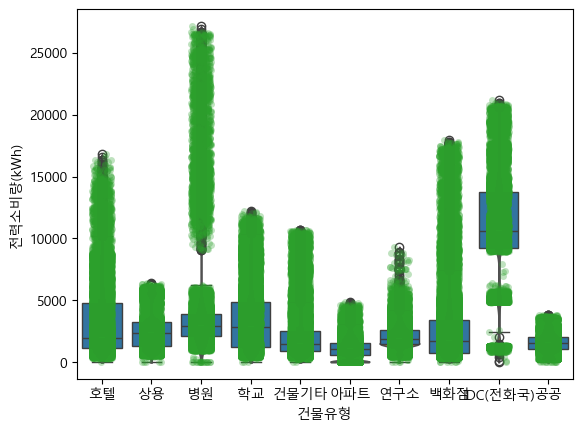

In [7]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt

sns.boxplot(data=df, x='건물유형', y=target)
sns.violinplot(data=df, x='건물유형', y=target, cut=0)
sns.stripplot(data=df, x='건물유형', y=target, alpha=0.3, jitter=0.2)


<Axes: xlabel='건물유형', ylabel='전력소비량(kWh)'>

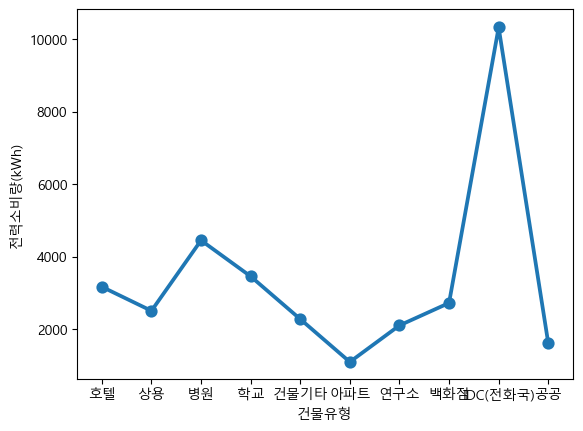

In [8]:
sns.pointplot(data=df, x='건물유형', y=target, errorbar='se')

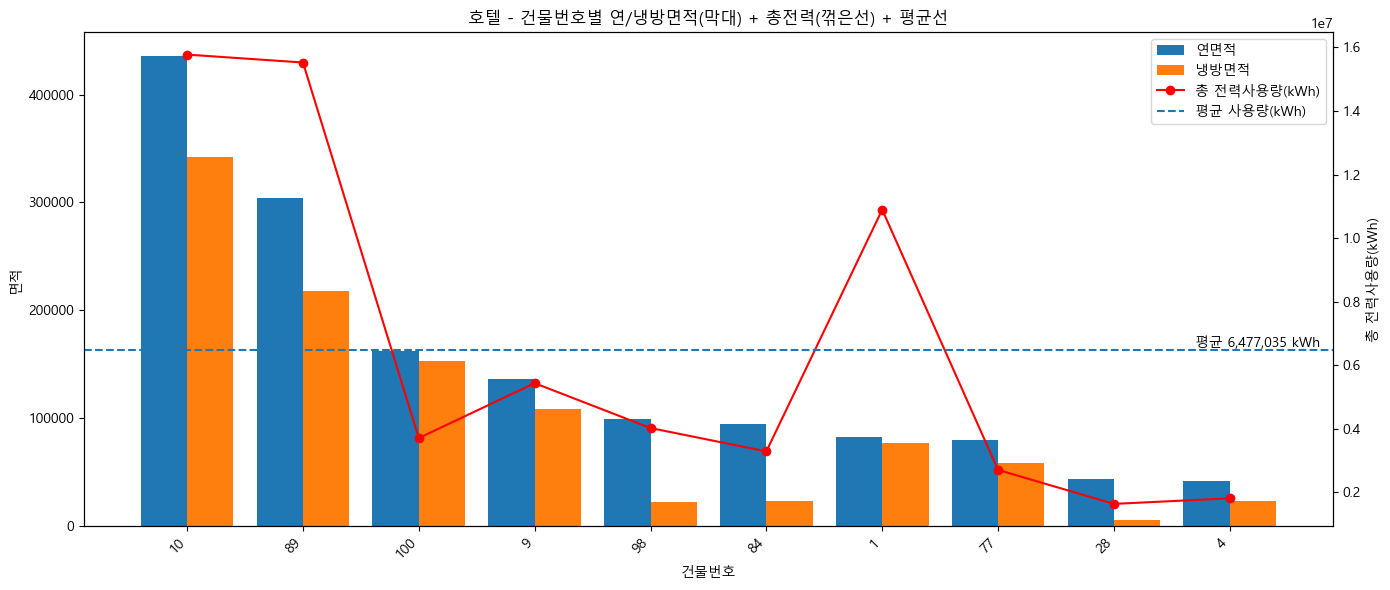

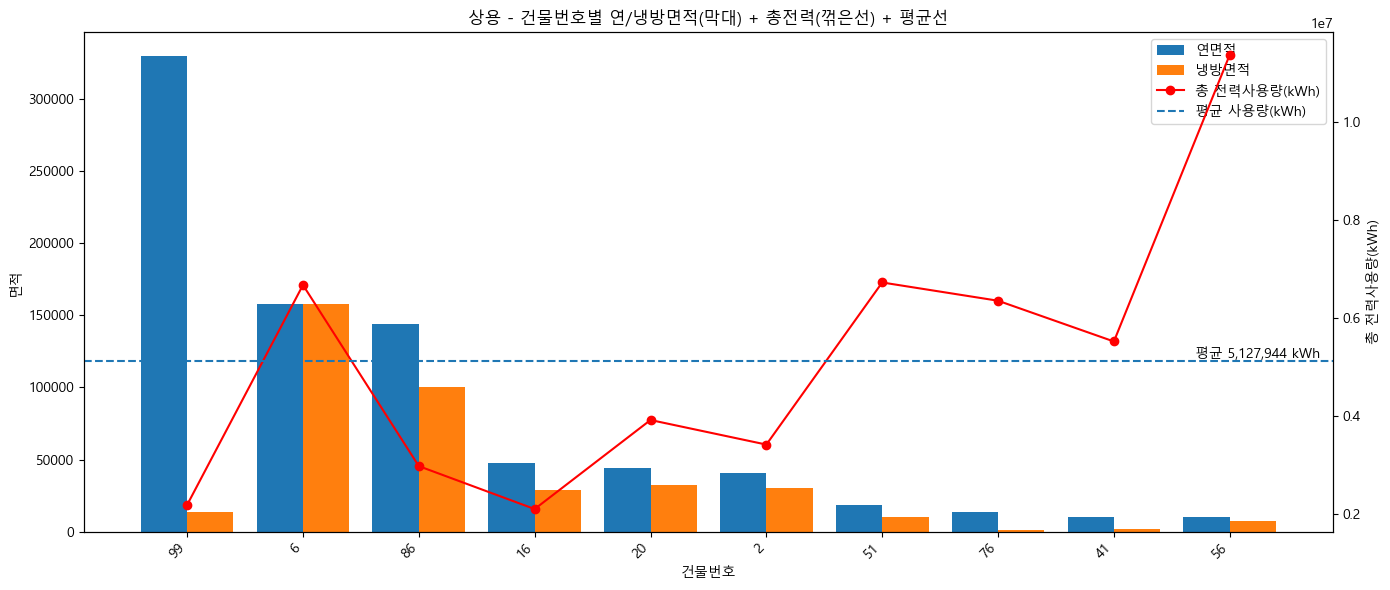

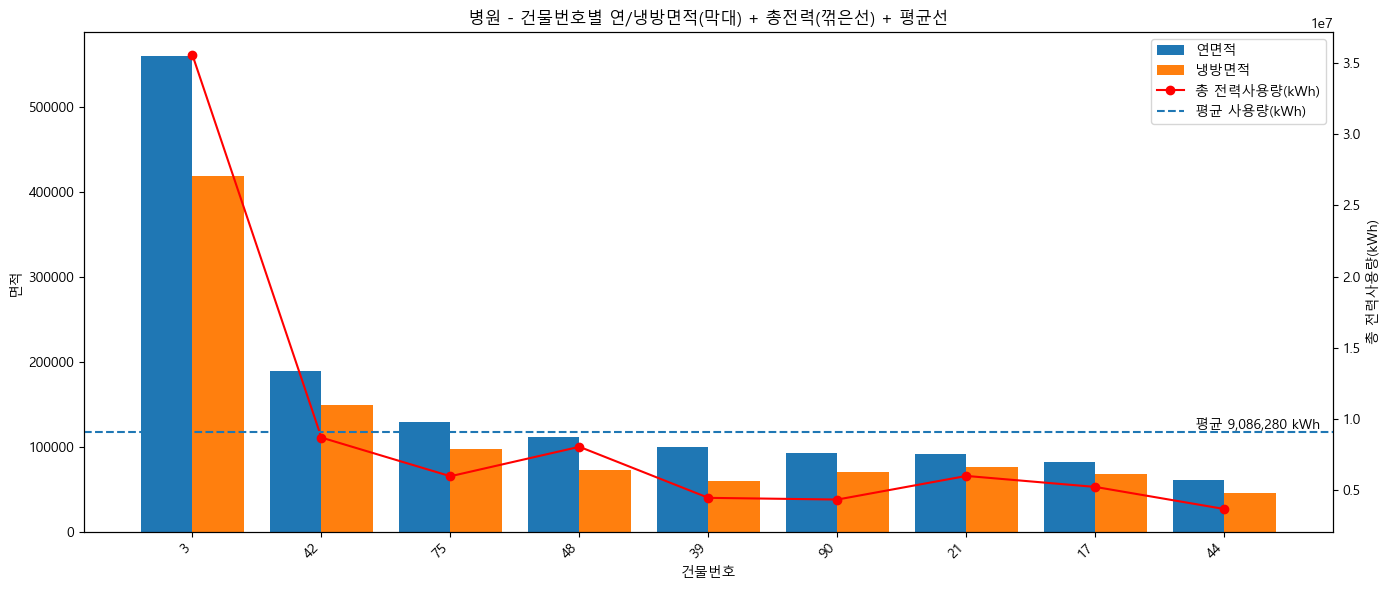

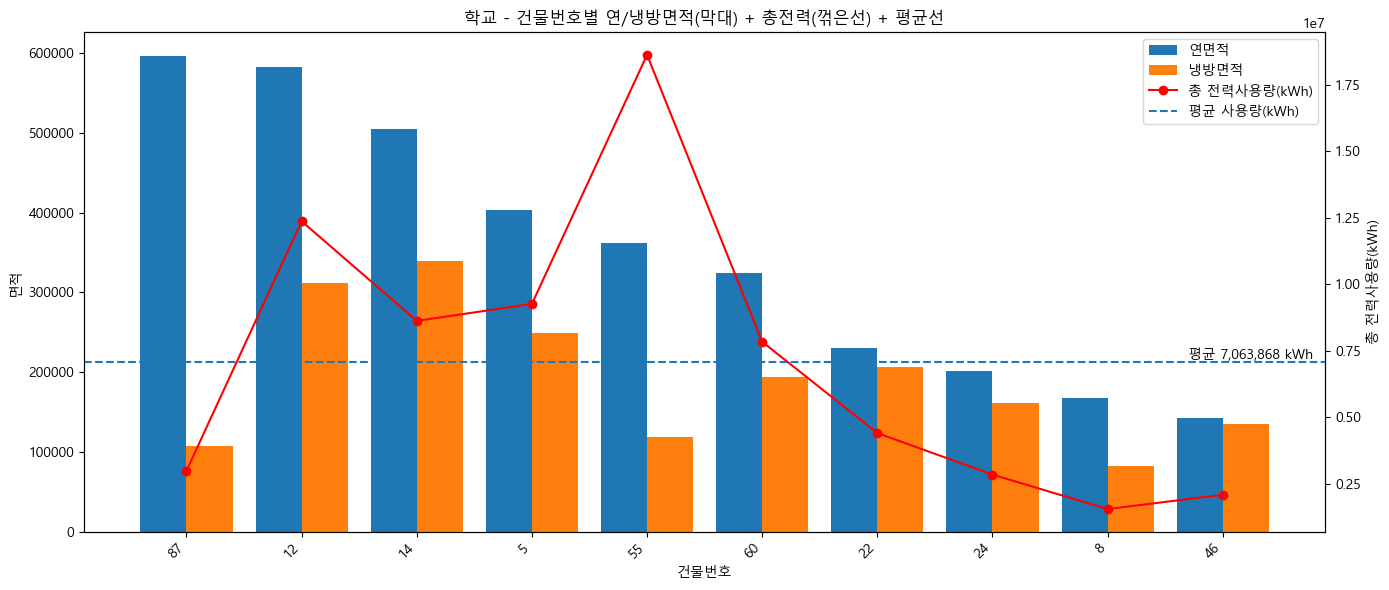

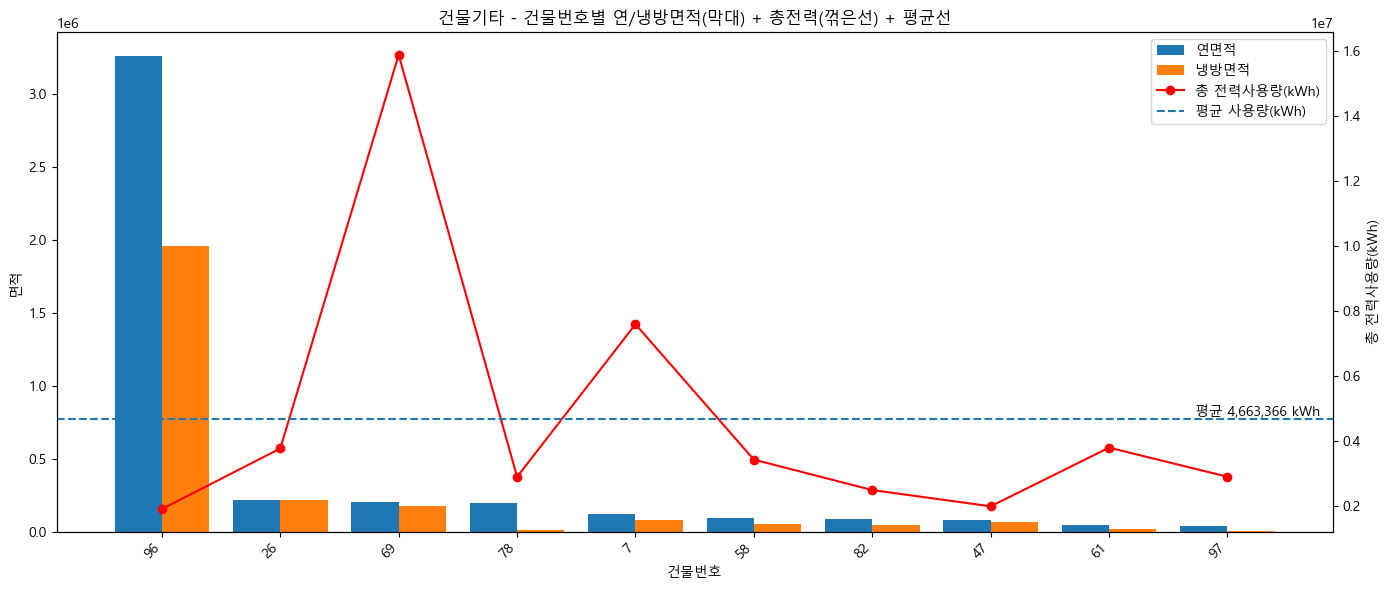

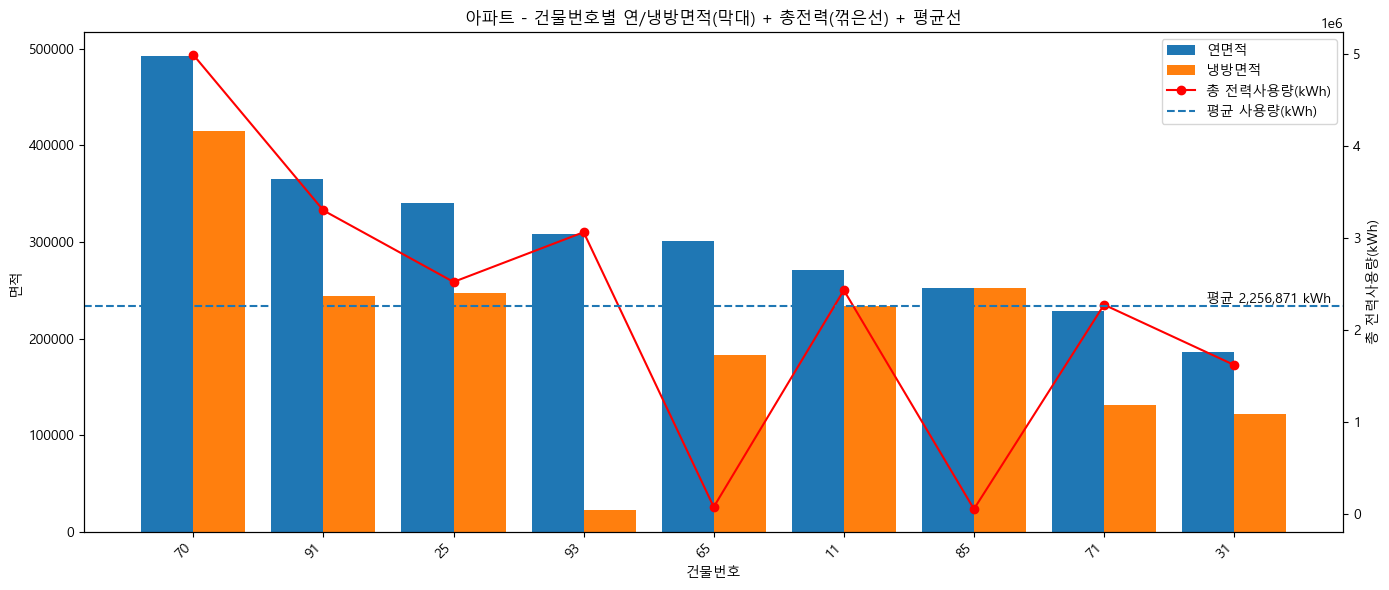

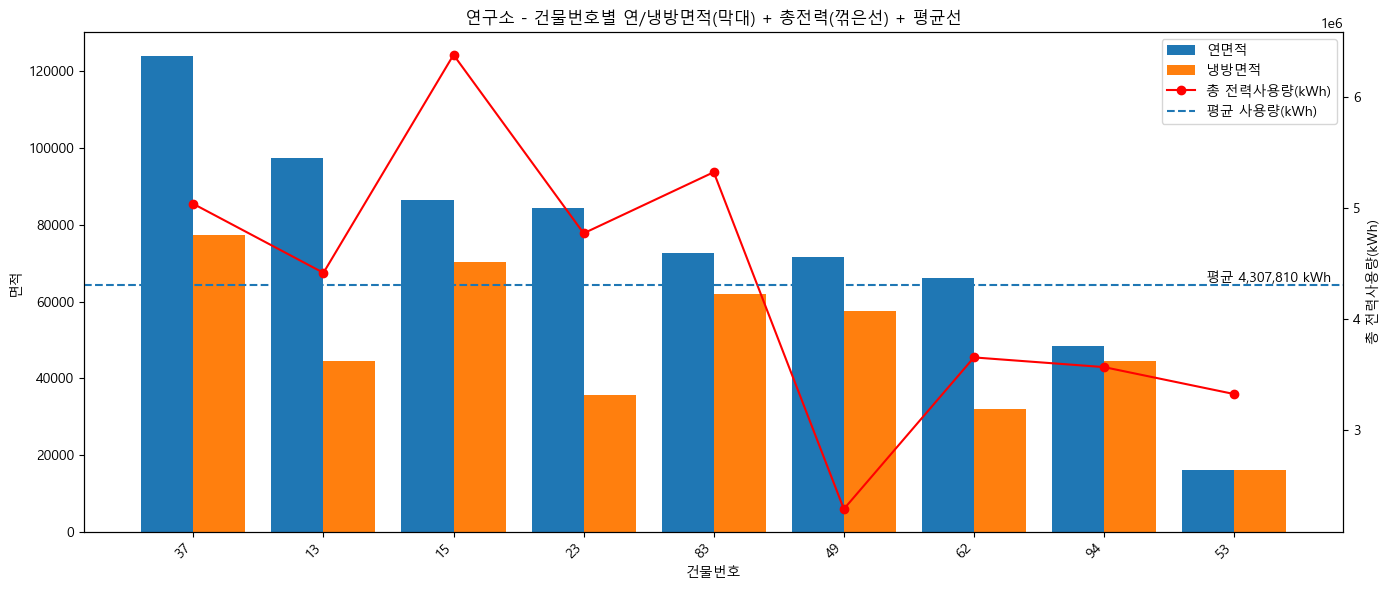

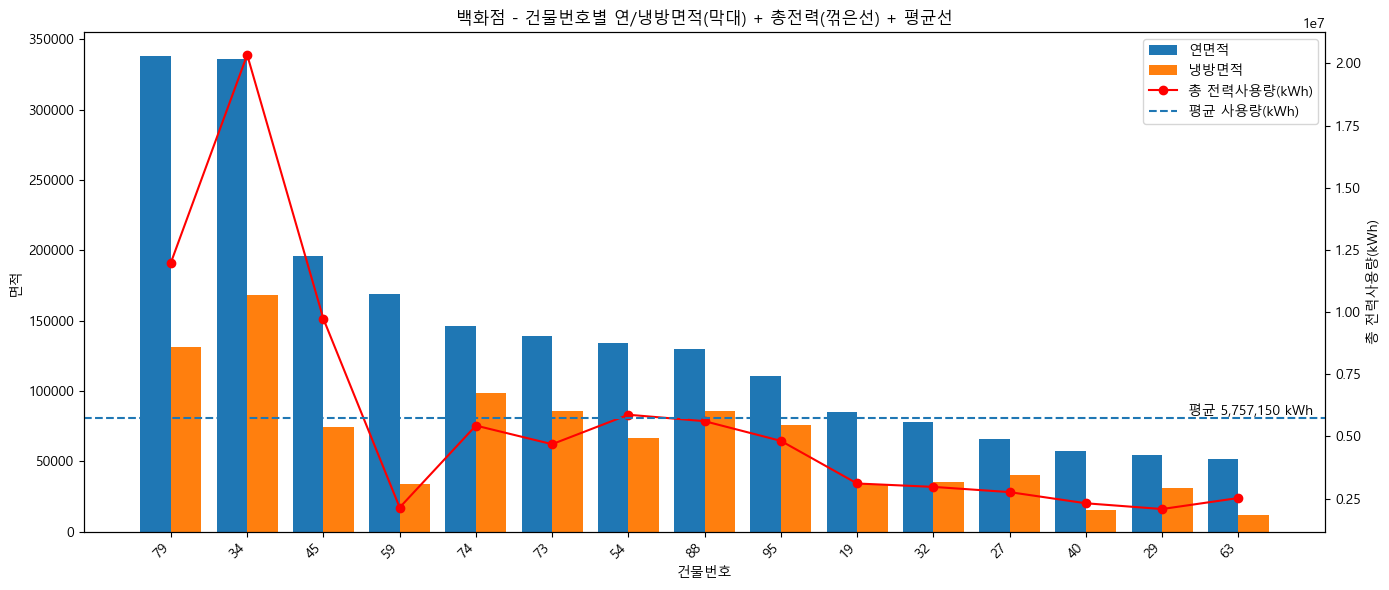

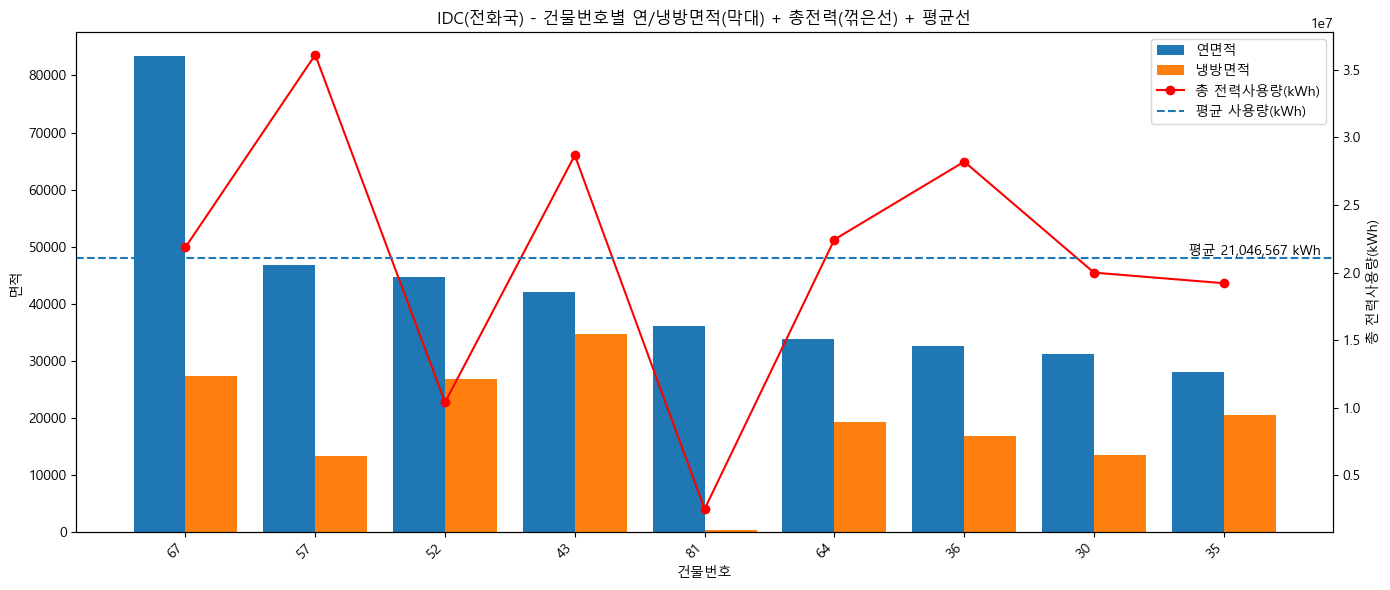

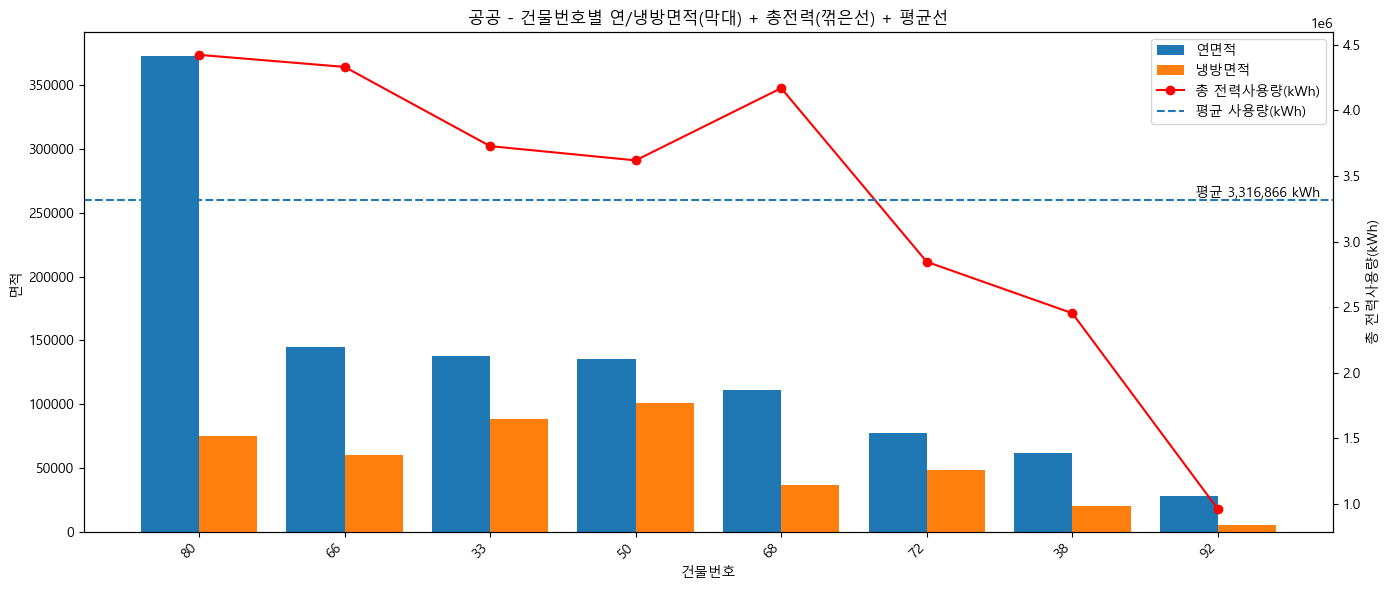

('/mnt/data/building_type_with_kwh_avg_charts.zip',
 '/mnt/data/plots_by_type_with_kwh_avg')

In [1]:
# -*- coding: utf-8 -*-
import os, re, zipfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# ---------- 0) Korean font (best-effort) ----------
installed = {f.name for f in fm.fontManager.ttflist}
for name in ["NanumGothic", "Malgun Gothic", "AppleGothic",
             "Noto Sans CJK KR", "Noto Sans CJK", "NotoSansKR-Regular"]:
    if name in installed:
        mpl.rcParams["font.family"] = name
        break
mpl.rcParams["axes.unicode_minus"] = False

# ---------- 1) Load CSVs ----------
train =  pd.read_csv('dataset/train.csv', encoding='utf-8')
bi   =  pd.read_csv('dataset/building_info.csv', encoding='utf-8')

# ---------- 2) Column detection ----------
def find_col(cols, patterns):
    for pat in patterns:
        for c in cols:
            if re.search(pat, str(c), flags=re.IGNORECASE):
                return c
    return None

bnum_bi  = find_col(bi.columns,    [r"건물번호", r"building[_\s-]*id", r"건물\s*ID", r"bldg[_\s-]*id"])
bnum_tr  = find_col(train.columns, [r"건물번호", r"building[_\s-]*id", r"건물\s*ID", r"bldg[_\s-]*id"])
btype_col = find_col(bi.columns,   [r"건물\s*유형", r"건물\s*용도", r"유형", r"용도", r"type"])
gfa_col   = find_col(bi.columns,   [r"연\s*면\s*적", r"총\s*면\s*적", r"연면적", r"GFA", r"floor\s*area"])
cool_col  = find_col(bi.columns,   [r"냉\s*방\s*면\s*적", r"냉방면적", r"cool.*area"])
kwh_col   = find_col(train.columns,[r"전력\s*소비\s*량.*kwh", r"전력\s*사용\s*량.*kwh", r"\bkwh\b", r"electric.*(use|consum)", r"power.*(use|consum)"])

if any(c is None for c in [bnum_bi, bnum_tr, btype_col, gfa_col, cool_col, kwh_col]):
    raise ValueError(f"컬럼 자동탐색 실패.\nbi cols: {list(bi.columns)}\ntrain cols: {list(train.columns)}")

# ---------- 3) Prepare merged ----------
for c in [gfa_col, cool_col]:
    bi[c] = pd.to_numeric(bi[c].astype(str).str.replace(",", ""), errors="coerce")
train[kwh_col] = pd.to_numeric(train[kwh_col], errors="coerce")

kwh_by_bld = (train.groupby(bnum_tr)[kwh_col]
                   .sum(min_count=1)
                   .rename("총전력사용량_kWh")
                   .reset_index()
                   .rename(columns={bnum_tr: "건물번호_key"}))

bi_slim = bi[[bnum_bi, btype_col, gfa_col, cool_col]].copy()
bi_slim = bi_slim.rename(columns={bnum_bi: "건물번호_key"})

merged = pd.merge(bi_slim, kwh_by_bld, on="건물번호_key", how="left")
merged["건물번호_key"] = merged["건물번호_key"].astype(str)

# ---------- 4) Plot per type (bars + line + avg line) ----------
out_dir = "/mnt/data/plots_by_type_with_kwh_avg"
os.makedirs(out_dir, exist_ok=True)

def slug(s):
    s = str(s)
    s = re.sub(r"[^\w\-]+", "_", s, flags=re.UNICODE)
    return s[:60]

TOP_N = 15
types = merged[btype_col].dropna().unique().tolist()

for t in types:
    sub = merged[merged[btype_col] == t].copy()
    sub["_sort_key"] = pd.to_numeric(sub[gfa_col], errors="coerce").fillna(0)
    sub = sub.sort_values("_sort_key", ascending=False).drop(columns=["_sort_key"])
    sub_top = sub.head(TOP_N)

    x = np.arange(len(sub_top))
    w = 0.4

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.bar(x - w/2, pd.to_numeric(sub_top[gfa_col], errors="coerce").values, width=w, label="연면적")
    ax1.bar(x + w/2, pd.to_numeric(sub_top[cool_col], errors="coerce").values, width=w, label="냉방면적")
    ax1.set_xlabel("건물번호")
    ax1.set_ylabel("면적")
    ax1.set_xticks(x, sub_top["건물번호_key"].astype(str).values, rotation=45, ha="right")

    # ---- line: total kWh ----
    ax2 = ax1.twinx()
    y_kwh = pd.to_numeric(sub_top["총전력사용량_kWh"], errors="coerce").fillna(0).values
    ax2.plot(x, y_kwh, marker="o", color="red", label="총 전력사용량(kWh)")
    ax2.set_ylabel("총 전력사용량(kWh)")

    # ---- avg line (mean usage) ----
    mean_kwh = pd.to_numeric(sub_top["총전력사용량_kWh"], errors="coerce").mean()
    if pd.notna(mean_kwh):
        ax2.axhline(mean_kwh, linestyle="--", label="평균 사용량(kWh)")
        # optional annotation
        ax2.text(0.99, mean_kwh, f"평균 {mean_kwh:,.0f} kWh",
                 va="bottom", ha="right", transform=ax2.get_yaxis_transform())

    # title & legend
    ax1.set_title(f"{t} - 건물번호별 연/냉방면적(막대) + 총전력(꺾은선) + 평균선")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right")

    fig.tight_layout()
    fig.savefig(f"{out_dir}/by_type_with_kwh_avg_{slug(t)}.png", dpi=200)
    plt.show()

# ---------- 5) Zip ----------
zip_path = "/mnt/data/building_type_with_kwh_avg_charts.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for fn in os.listdir(out_dir):
        zf.write(os.path.join(out_dir, fn), arcname=f"plots_by_type_with_kwh_avg/{fn}")

zip_path, out_dir


In [2]:
# =========================================
# Plotly + ipywidgets 대시보드 (수정본)
# - 1) 건물유형 선택 → 2) 건물번호 선택 → 3) 시간/일/주 단위 시계열
# - 'H' 경고 해결: 소문자 'h' 사용
# - 마지막 출력: display(ui)  ✅
# =========================================
import os, re
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display
import ipywidgets as widgets

import plotly.io as pio
pio.renderers.default = "colab"

# (Colab일 때 위젯 표시 활성화)
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

# ---------- 1) 데이터 로드 ----------
train =  pd.read_csv('dataset/train.csv', encoding='utf-8')
bi   =  pd.read_csv('dataset/building_info.csv', encoding='utf-8')

# ---------- 2) 컬럼 자동 탐색 ----------
def find_col(cols, patterns):
    for pat in patterns:
        for c in cols:
            if re.search(pat, str(c), flags=re.IGNORECASE):
                return c
    return None

bnum_tr  = find_col(train.columns, [r"건물번호", r"building[_\s-]*id", r"건물\s*ID", r"bldg[_\s-]*id"])
bnum_bi  = find_col(bi.columns,    [r"건물번호", r"building[_\s-]*id", r"건물\s*ID", r"bldg[_\s-]*id"])
btype_col= find_col(bi.columns,    [r"건물\s*유형", r"건물\s*용도", r"유형", r"용도", r"type"])
time_col = find_col(train.columns, [r"일시", r"date[_\s-]*time", r"timestamp", r"datetime", r"date"])
kwh_col  = find_col(train.columns, [r"전력\s*소비\s*량.*kwh", r"전력\s*사용\s*량.*kwh", r"\bkwh\b", r"electric.*(use|consum)", r"power.*(use|consum)"])

missing = [name for name, col in [
    ("건물번호(train)", bnum_tr), ("건물번호(bi)", bnum_bi), ("건물유형", btype_col),
    ("일시", time_col), ("전력소비량(kWh)", kwh_col)
] if col is None]
assert not missing, f"다음 컬럼을 찾지 못했습니다: {missing}\ntrain cols={list(train.columns)}\nbi cols={list(bi.columns)}"

# ---------- 3) 병합 및 전처리 ----------
train[time_col] = pd.to_datetime(train[time_col], errors="coerce")
train[kwh_col]  = pd.to_numeric(train[kwh_col], errors="coerce")

bi_slim = bi[[bnum_bi, btype_col]].copy().rename(columns={bnum_bi: "건물번호_key"})
df = (train.rename(columns={bnum_tr: "건물번호_key"})
            .merge(bi_slim, on="건물번호_key", how="left"))

df_valid = df.dropna(subset=[time_col, kwh_col, "건물번호_key", btype_col]).copy()
df_valid["건물번호_key"] = df_valid["건물번호_key"].astype(str)
df_valid[btype_col]      = df_valid[btype_col].astype(str)

types = sorted(df_valid[btype_col].unique().tolist())

def bld_options_for(t):
    opts = sorted(df_valid.loc[df_valid[btype_col]==t, "건물번호_key"].unique().tolist())
    return opts if opts else ["(데이터 없음)"]

# ---------- 4) 위젯 ----------
type_dd = widgets.Dropdown(options=types, description="건물유형:", layout=widgets.Layout(width="35%"))
bld_dd  = widgets.Dropdown(options=bld_options_for(types[0] if types else None),
                           description="건물번호:", layout=widgets.Layout(width="35%"))

# ⚠️ 'H' 대신 소문자 'h' 사용
freq_tb = widgets.ToggleButtons(options=[("시간별","h"), ("일별","D"), ("주별","W")],
                                value="h", description="집계:")

# ---------- 5) Plotly FigureWidget ----------
fig = go.FigureWidget(layout=dict(
    height=520, margin=dict(l=50, r=30, t=50, b=40),
    xaxis_title="일시", yaxis_title="전력사용량 (kWh)",
    title="건물별 전력사용량 시계열"
))

# ---------- 6) 콜백 ----------
def update_building_options(change=None):
    new_opts = bld_options_for(type_dd.value)
    bld_dd.options = new_opts
    if bld_dd.value not in new_opts:
        bld_dd.value = new_opts[0] if new_opts else None

def update_figure(change=None):
    t  = type_dd.value
    b  = bld_dd.value
    fq = freq_tb.value               # 'h' / 'D' / 'W'
    label_map = {'h':'시간', 'D':'일', 'W':'주'}

    with fig.batch_update():
        fig.data = []
        if (not t) or (not b) or b == "(데이터 없음)":
            fig.update_layout(title=f"{t} - 데이터 없음")
            return

        sub = df_valid[(df_valid[btype_col]==t) & (df_valid["건물번호_key"]==str(b))]
        if sub.empty:
            fig.update_layout(title=f"{t} / {b} - 데이터 없음")
            return

        ts = (sub.set_index(time_col)[kwh_col]
                .resample(fq)        # ✅ 'h' 사용
                .sum(min_count=1)
                .dropna())
        if ts.empty:
            fig.update_layout(title=f"{t} / {b} - 집계 결과 없음")
            return

        fig.add_scatter(x=ts.index, y=ts.values, mode="lines+markers",
                        name=f"{b} ({label_map[fq]})")
        fig.update_layout(title=f"{t} / 건물번호 {b} - 전력사용량 ({label_map[fq]} 단위)")

# 초기화 & 이벤트 연결
update_building_options()
update_figure()
type_dd.observe(update_building_options, names="value")
type_dd.observe(update_figure,          names="value")
bld_dd.observe(update_figure,           names="value")
freq_tb.observe(update_figure,          names="value")

# ---------- 7) UI 표시 (✅ 여기가 핵심) ----------
ui = widgets.VBox([widgets.HBox([type_dd, bld_dd, freq_tb]), fig])
display(ui)